<a href="https://colab.research.google.com/github/mastgm0817/DeepLearning/blob/main/mastgm0817/cats_and_dogs_%EC%9D%B4%EC%A7%84%EB%B6%84%EB%A5%98%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip cats_and_dogs_filtered.zip

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

train_config = transforms.Compose([transforms.Resize((224,224)),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor()])
test_config = transforms.Compose([transforms.Resize((224,224)),
                                   transforms.ToTensor()])

train_dset = datasets.ImageFolder('/content/cats_and_dogs_filtered/train',train_config)
test_dset = datasets.ImageFolder('/content/cats_and_dogs_filtered/validation',test_config)

train_loader = DataLoader(train_dset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dset, batch_size=32, shuffle=False)


In [ ]:
model = models.vgg16(pretrained=True)
print(model)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for param in model.features.parameters():
  param.require_grad = False

In [ ]:
model.classifier[-1] = nn.Sequential(
    nn.Linear(model.classifier[-1].in_features,1),
    nn.Sigmoid()
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(model.to(device))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-6)


In [ ]:
def train(model, criterion, optimizer, loader):
  epoch_loss = 0
  epoch_acc = 0

  model.train()

  for X_batch, y_batch in loader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device).float().view(-1,1)
    optimizer.zero_grad()
    hypothesis = model(X_batch)
    loss = criterion(hypothesis, y_batch)
    loss.backward()
    optimizer.step()
    y_predicted = hypothesis >= 0.5
    acc = (y_predicted == y_batch).float().mean()
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(loader), epoch_acc / len(loader)


In [ ]:
def evaluate(model, criterion, loader):
  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  with torch.no_grad():
    for X_batch, y_batch in loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device).float().view(-1,1)
      hypothesis = model(X_batch)
      loss = criterion(hypothesis, y_batch)
      y_predicted = hypothesis >= 0.5
      acc = (y_predicted == y_batch).float().mean()
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
n_epochs = 10
for epoch in range(1, n_epochs+1):
  loss, acc = train(model, criterion, optimizer, train_loader)

  test_loss, test_acc = evaluate(model, criterion, test_loader)

  print(f'epoch: {epoch}, loss: {loss:.2f}, acc: {acc:.2f}, test_loss: {test_loss:.3f}, test_acc {test_acc:.3f}')

epoch: 1, loss: 0.56, acc: 0.73, test_loss: 0.463, test_acc 0.896
epoch: 2, loss: 0.39, acc: 0.88, test_loss: 0.297, test_acc 0.938
epoch: 3, loss: 0.25, acc: 0.93, test_loss: 0.176, test_acc 0.958
epoch: 4, loss: 0.16, acc: 0.96, test_loss: 0.116, test_acc 0.965
epoch: 5, loss: 0.11, acc: 0.97, test_loss: 0.087, test_acc 0.967
epoch: 6, loss: 0.09, acc: 0.97, test_loss: 0.072, test_acc 0.972
epoch: 7, loss: 0.07, acc: 0.97, test_loss: 0.063, test_acc 0.976
epoch: 8, loss: 0.06, acc: 0.98, test_loss: 0.058, test_acc 0.979
epoch: 9, loss: 0.05, acc: 0.98, test_loss: 0.054, test_acc 0.980
epoch: 10, loss: 0.04, acc: 0.99, test_loss: 0.051, test_acc 0.980


아래 사진은 고양이입니다.


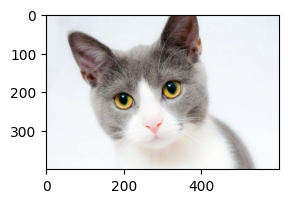

아래 사진은 개 입니다.


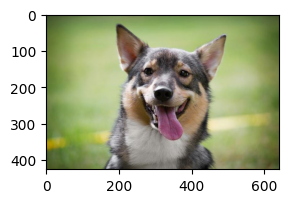

아래 사진은 개 입니다.


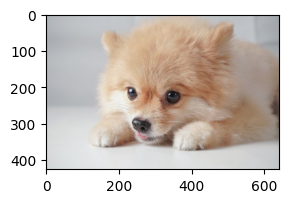

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

imgs = []
image = []
imgs.append(Image.open('/content/imgs/cat.jpeg'))
imgs.append(Image.open('/content/imgs/dog1.jpeg'))
imgs.append(Image.open('/content/imgs/dog2.jpg'))
for i in imgs:
  test_config = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor()])
  image = test_config(i)
  image = image.unsqueeze(0)
  image = image.to(device)
  # 모델 예측 수행
  with torch.no_grad():
      prediction = model(image)
  # 결과 출력
  if prediction >= 0.5:
    print("아래 사진은 개 입니다.")
    plt.figure(figsize=(3,3))
    plt.imshow(i)
    plt.show()
    
  else:
    print("아래 사진은 고양이입니다.")
    plt.figure(figsize=(3,3))
    plt.imshow(i)
    plt.show()
  

